## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt



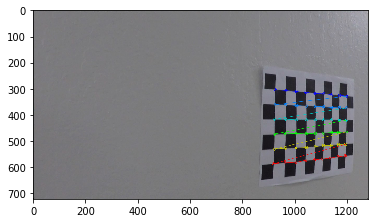

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        #cv2.waitKey(500) 
        
#cv2.destroyAllWindows()


## Undistort Chessboard

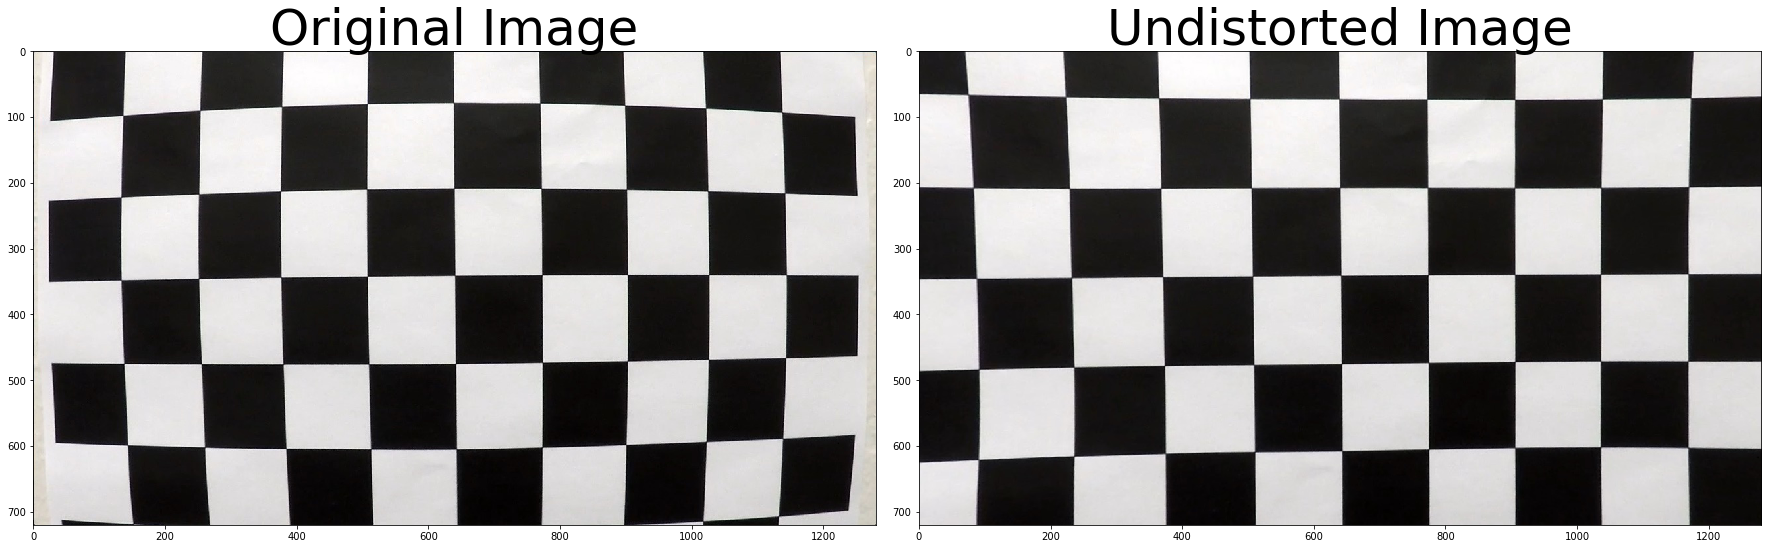

In [3]:
img = mpimg.imread('../camera_cal/calibration1.jpg')
gray= gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## RAW test image Distortion correction

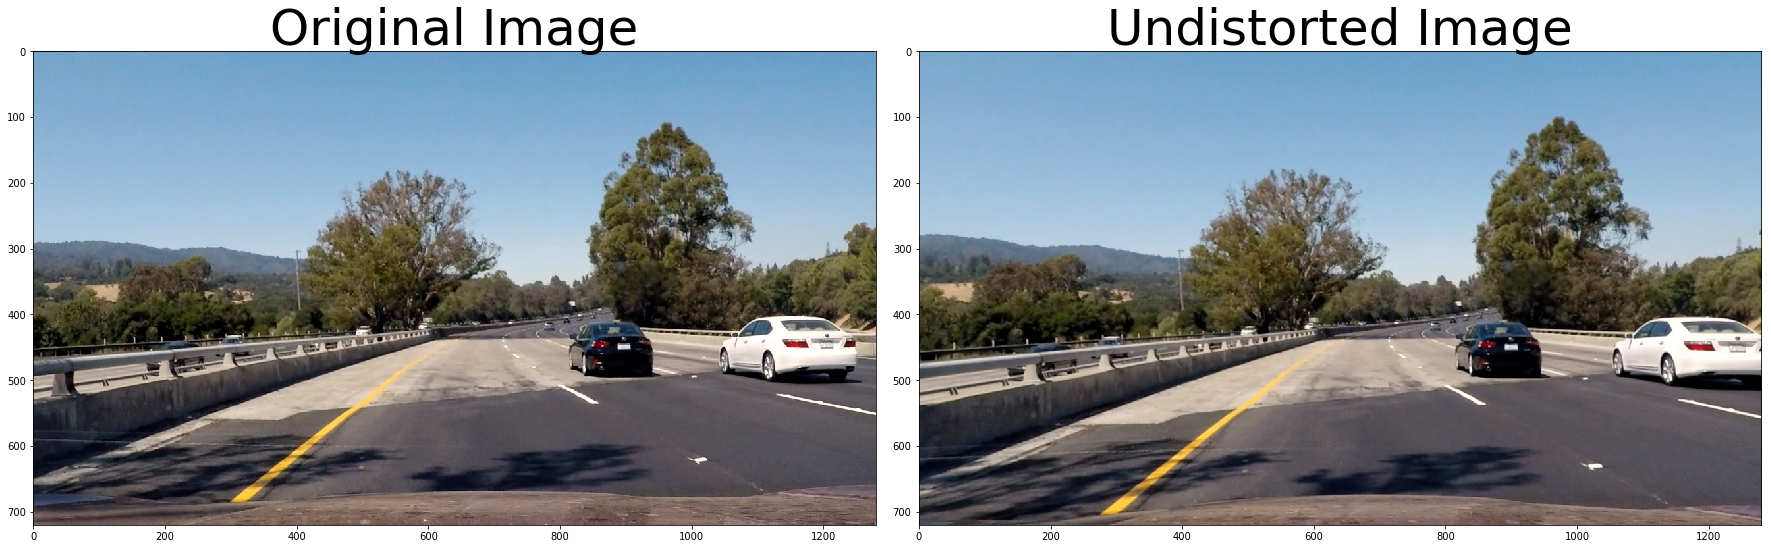

In [21]:
# Applying distortion correction to Raw image
img = mpimg.imread('../test_images/test4.jpg')
gray= gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


##  Directional Gradient

In [22]:
def abs_sobel_thresh(undistorted, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

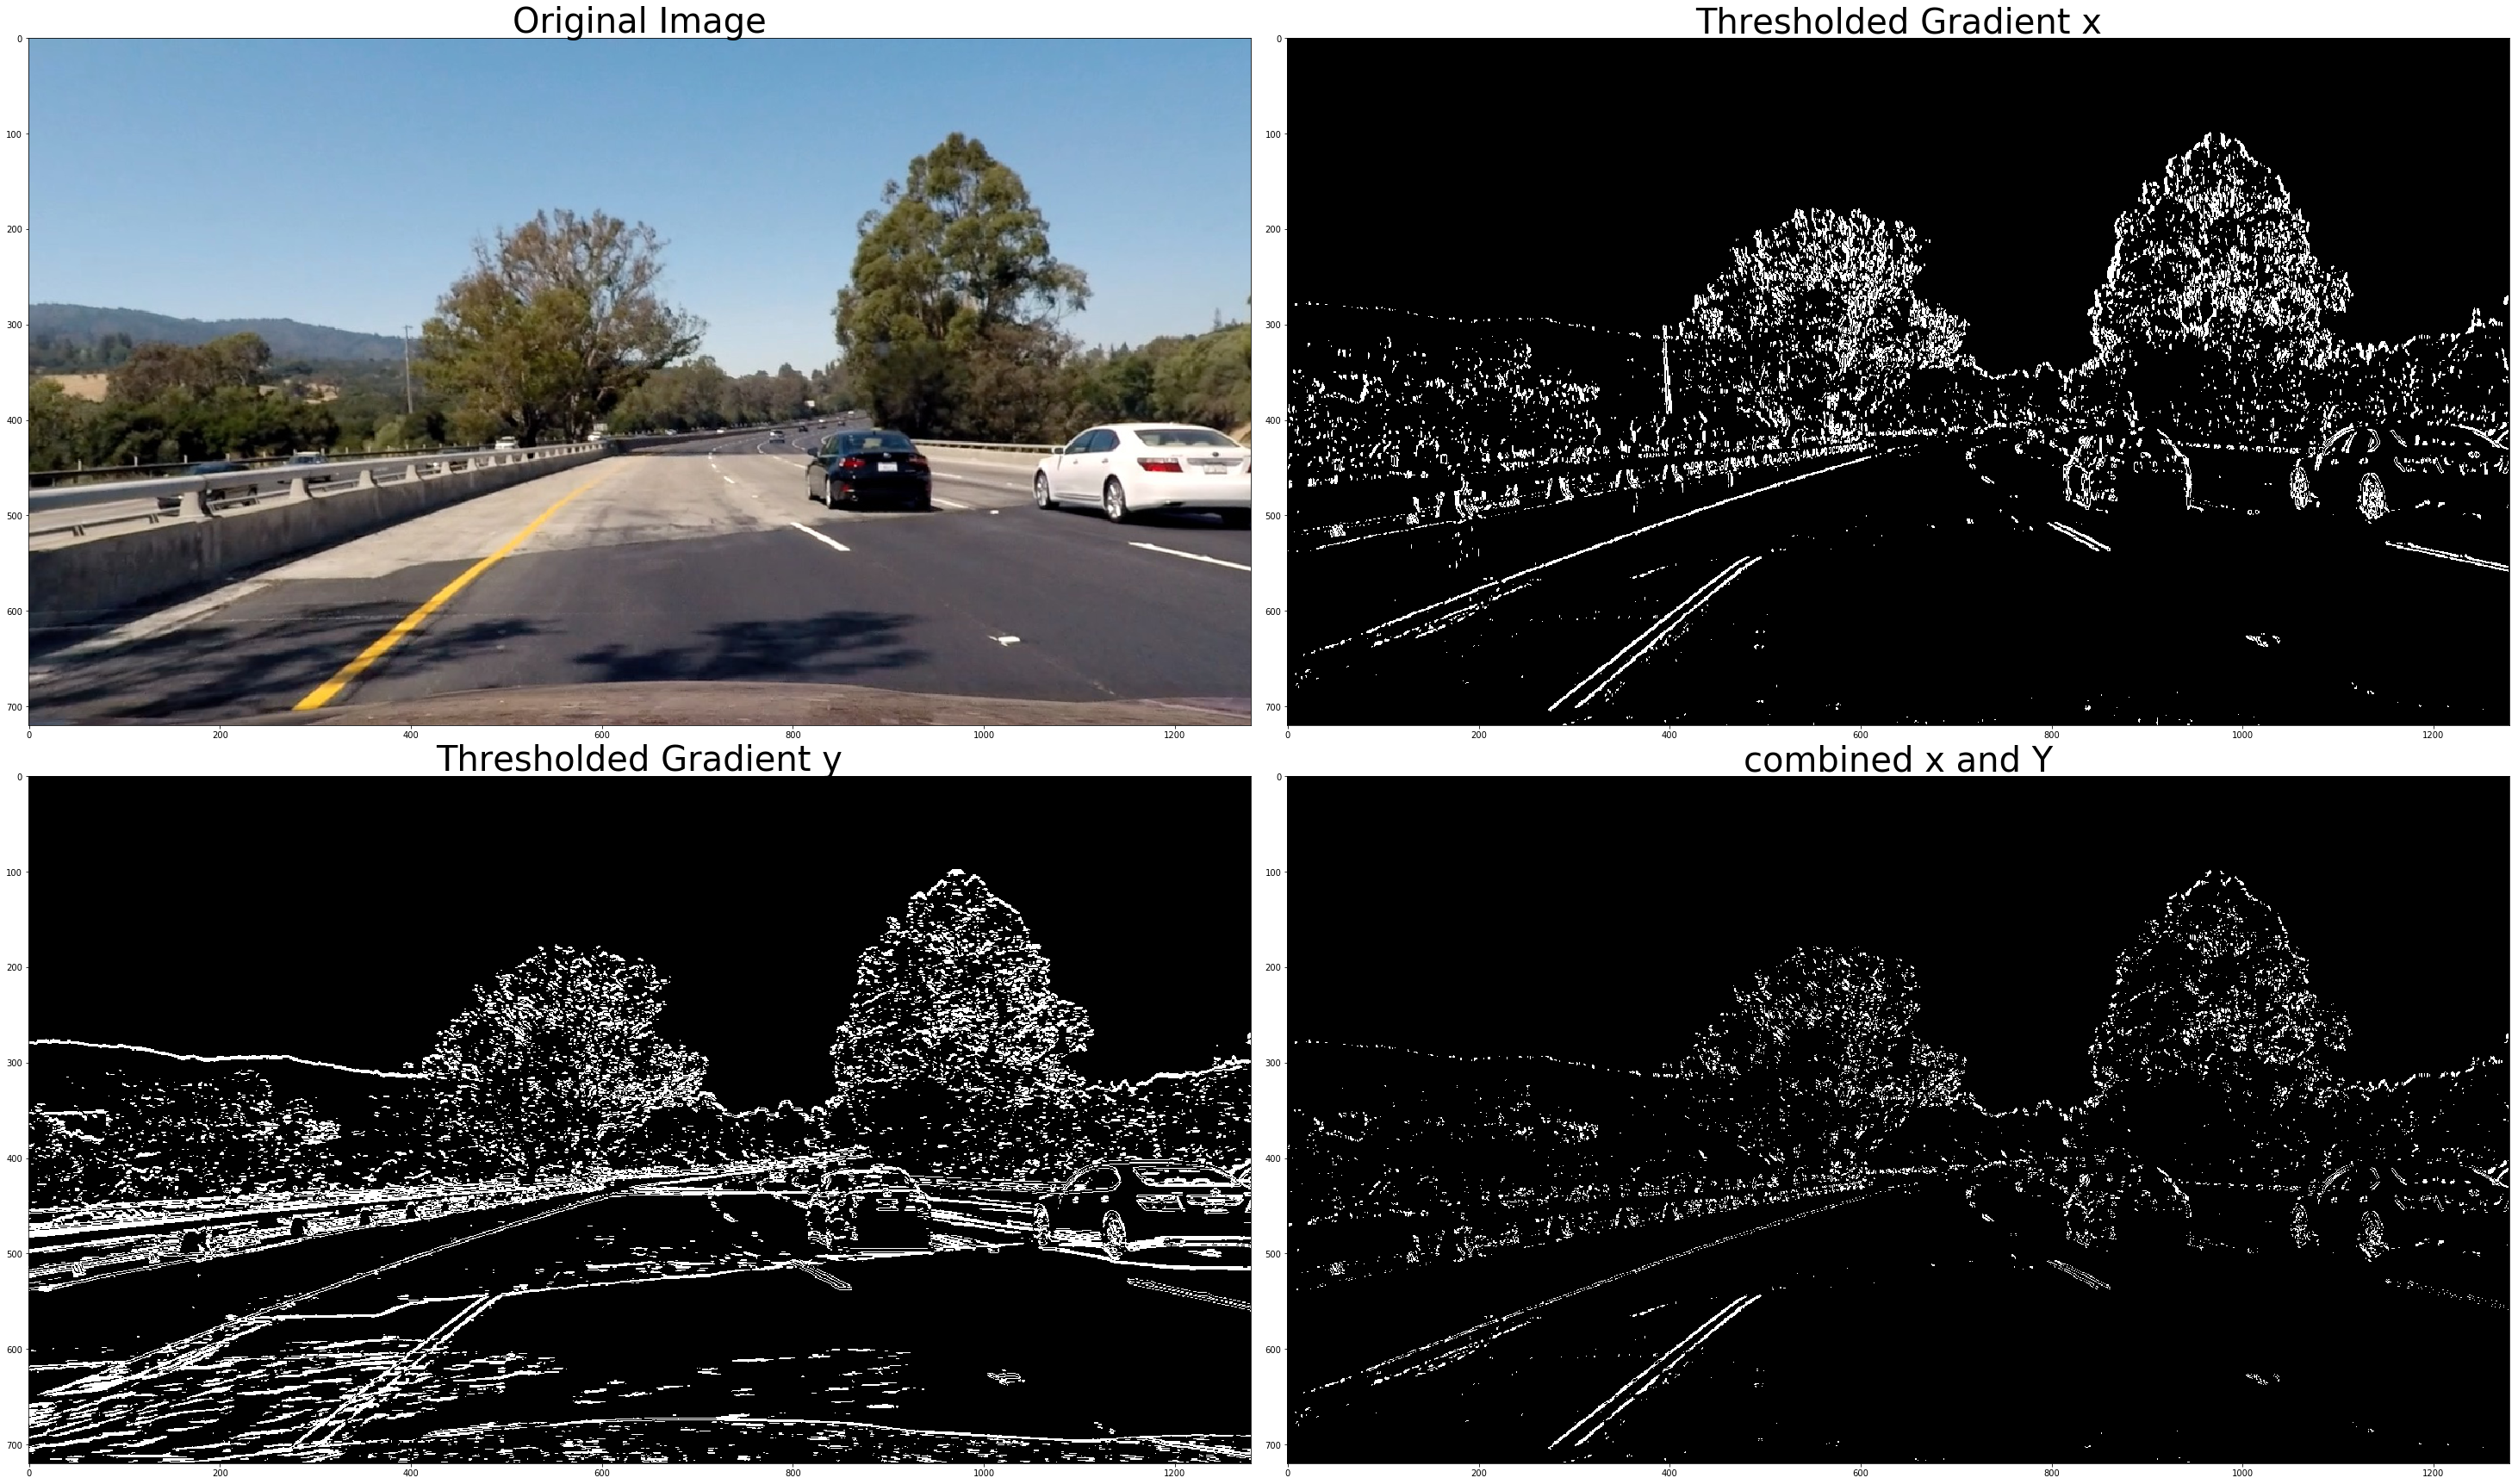

In [44]:
# Run the function
grad_binary_x = abs_sobel_thresh(undistorted, orient='x', thresh_min=20, thresh_max=100)
grad_binary_y = abs_sobel_thresh(undistorted, orient='y', thresh_min=20, thresh_max=100)
combined = np.zeros_like(grad_binary_x)
combined[((grad_binary_x == 1) & (grad_binary_y == 1))] = 1 #| ((mag_binary == 1) & (dir_binary == 1))] = 1
# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(40, 26))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.set_title('Thresholded Gradient x', fontsize=40)
ax3.imshow(grad_binary_y, cmap='gray')
ax3.set_title('Thresholded Gradient y', fontsize=40)
ax4.imshow(combined, cmap='gray')
ax4.set_title('combined x and Y', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##  Magnitude Threshold Gradient

In [45]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(image, sobel_kernel=3, mag_thresh=(20, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output  



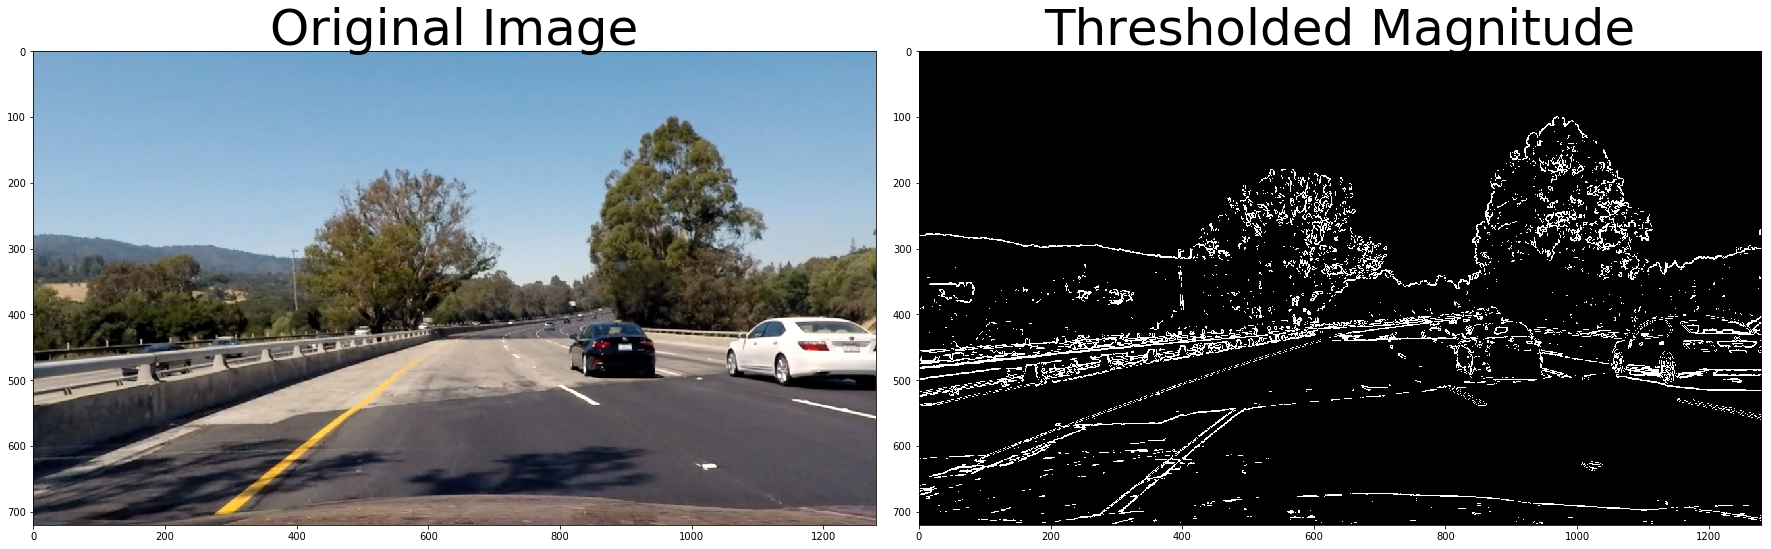

In [46]:
# Run the function
mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(40, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##  Directional Threshold

In [47]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(undistorted, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_finale = np.arctan2(abs_sobely, abs_sobelx)
    binary_output =  np.zeros_like(abs_finale)
    binary_output[(abs_finale >= thresh[0]) & (abs_finale <= thresh[1])] = 1
    return binary_output

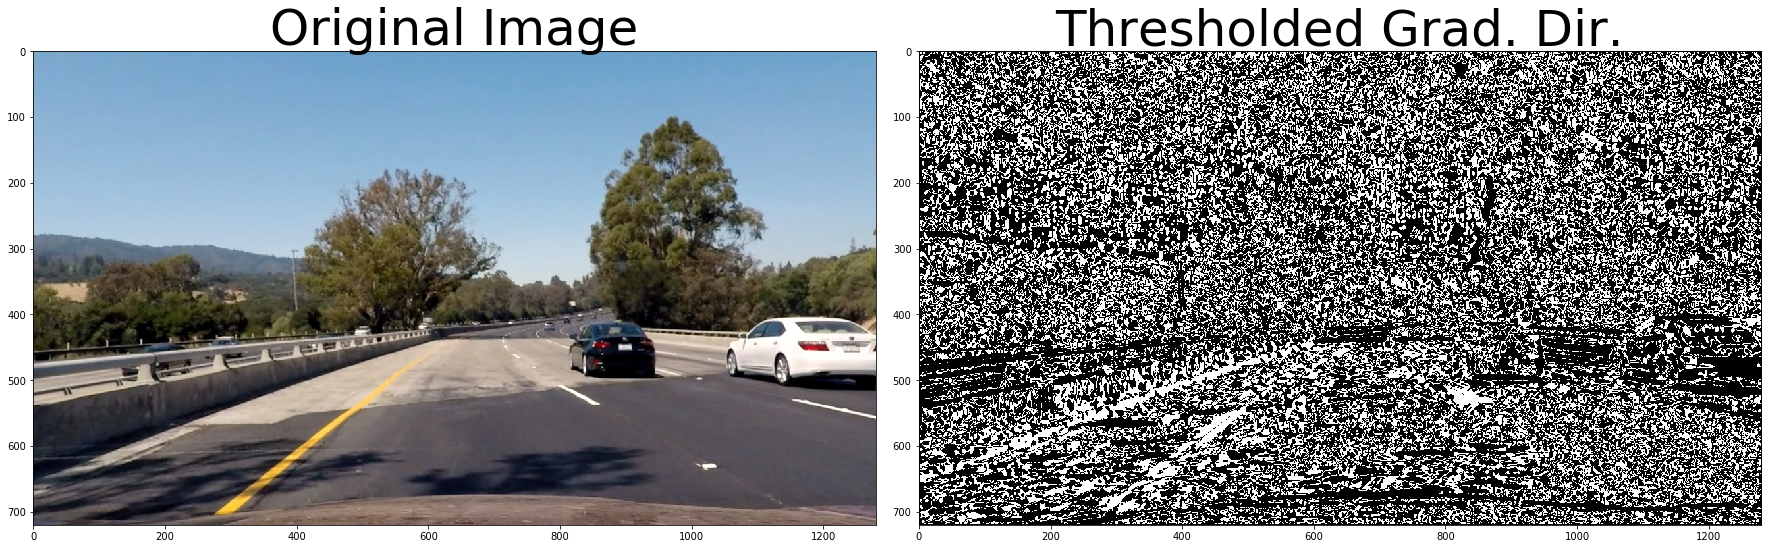

In [48]:
# Run the function
dir_binary = dir_threshold(undistorted, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [49]:
combined = np.zeros_like(dir_binary)
combined[((grad_binary_x == 1) & (grad_binary_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

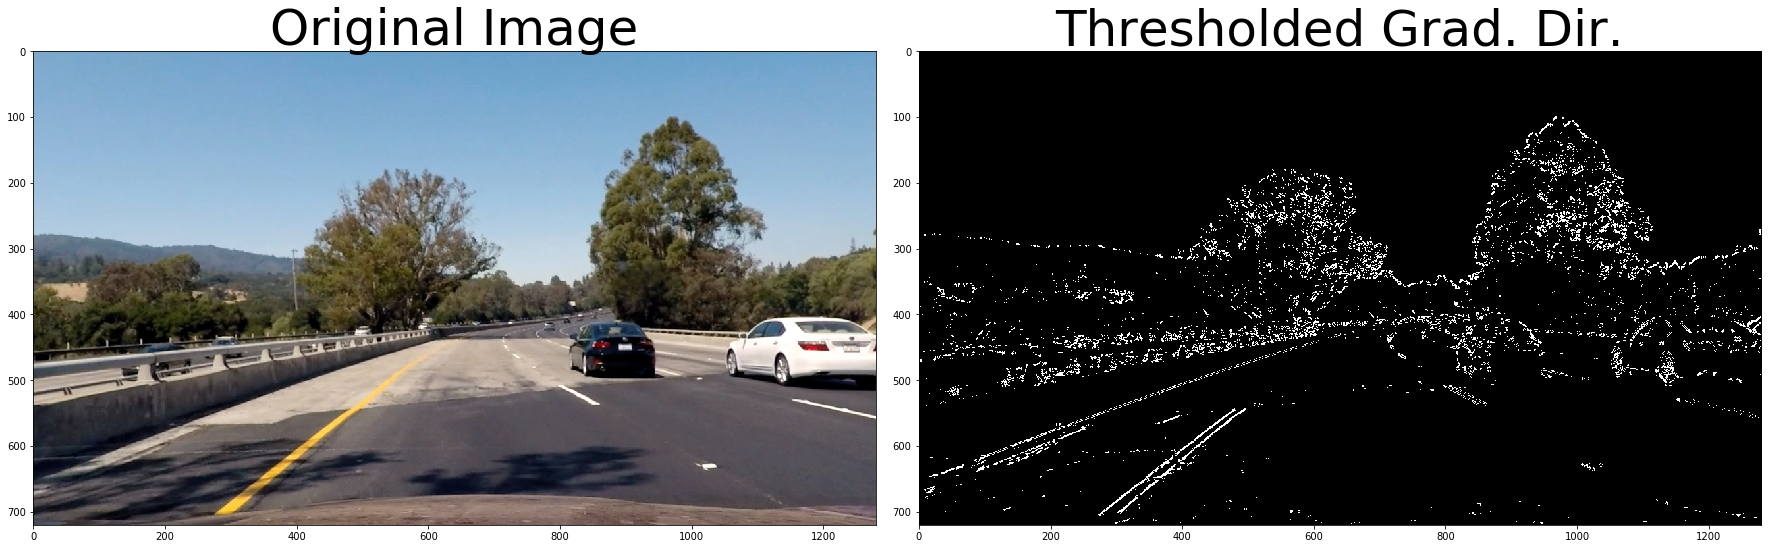

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## And so on and so forth...

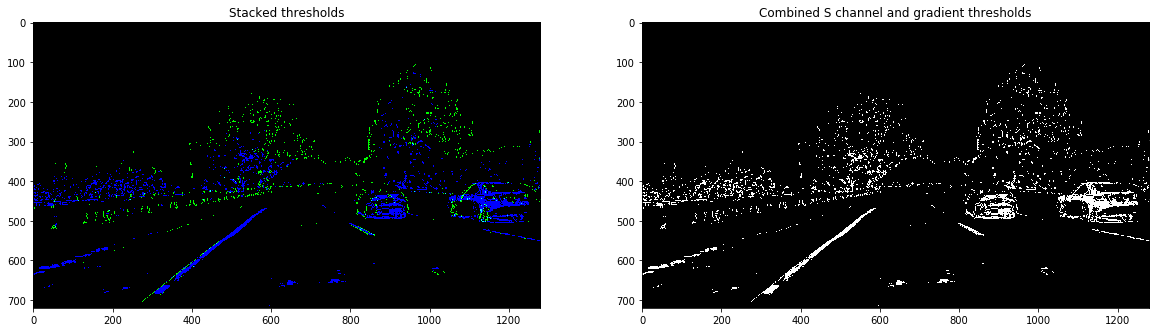

In [51]:
# Use color transforms, gradients, etc., to create a thresholded binary image

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
abs_sobely = np.absolute(sobely)
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

# Threshold x gradient
thresh_min = 50
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobelx)
sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1

# Threshold y gradient
thresh_min = 700
thresh_max = 100
sybinary = np.zeros_like(scaled_sobely)
sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 160
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## And so on and so forth...

In [ ]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped
